In [ ]:
#LLMs[1][2][3] are used to create this code.
#[1] OpenAI. GPT-4o. (2025). Open AI. [Online]. Available: https://chatgpt.com/?model=gpt-4o
#[2] Google. 2.5 pro. (2025). Google. [Online] Available: https://gemini.google.com/app?hl=ja 
#[3] GitHub. GitHub Copilot. (2025). GitHub. [Online]. 


In [ ]:
%cd /content/drive/MyDrive/works/pattern/ # pleae change this code depens on your environment

/content/drive/MyDrive/works/pattern


In [1]:
# !pip install japanize-matplotlib

In [78]:
# --- 1. ライブラリのインポート ---
import json
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
# import japanize_matplotlib
from PIL import Image, ImageOps
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import EfficientNetV2B0, EfficientNetV2B2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score

In [79]:
# --- 2. データの読み込みと特徴量エンジニアリング ---

# 2.1 データの読み込みと統合 (★複合エラーのJSONを追加)
json_files = {
    'good': './point_data/good.json',
    'error_hiza': './point_data/hiza.json',
    'error_ude': './point_data/ude.json',
    'error_kakato': './point_data/kakato.json',
    'hiza_kakato': './point_data/hiza_kakato.json', # 追加
    'ude_kakato': './point_data/ude_kakato.json',   # 追加
    'ude_hiza': './point_data/ude_hiza.json'       # 追加
}
all_data = []
for label, file_path in json_files.items():
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
            for item in data:
                item['source'] = label
            all_data.extend(data)
    except FileNotFoundError:
        print(f"警告: ファイルが見つかりませんでした: {file_path}")

df = pd.DataFrame(all_data)
print("--- データ読み込み完了 ---")
print(f"合計データ数: {len(df)}")
print(df['source'].value_counts())


# 2.2 特徴量計算関数の定義 (変更なし)
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba, bc = a - b, c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

def extract_final_features(landmarks):
    # (この関数の中身は変更なし)
    global front, rear
    if not landmarks: return pd.Series([np.nan] * 7)  # 空
    coords = {lm: [data['x'], data['y'], data['z']] for lm, data in landmarks.items()}
    if landmarks.get('LEFT_KNEE') and landmarks.get('RIGHT_KNEE'):
        if coords['LEFT_KNEE'][0] > coords['RIGHT_KNEE'][0]: front, rear = 'LEFT', 'RIGHT'
        else: front, rear = 'RIGHT', 'LEFT'
    else: front, rear = 'LEFT', 'RIGHT'

    shoulder_center = (np.array(coords.get('LEFT_SHOULDER', [0,0,0])) + np.array(coords.get('RIGHT_SHOULDER', [0,0,0]))) / 2
    hip_center = (np.array(coords.get('LEFT_HIP', [0,0,0])) + np.array(coords.get('RIGHT_HIP', [0,0,0]))) / 2
    wrist_center = (np.array(coords.get('LEFT_WRIST', [0,0,0])) + np.array(coords.get('RIGHT_WRIST', [0,0,0]))) / 2
    ankle_center = (np.array(coords.get(f'{front}_ANKLE', [0,0,0])) + np.array(coords.get(f'{rear}_ANKLE', [0,0,0]))) / 2
    front_knee_angle = calculate_angle(coords.get(f'{front}_HIP', [0,0,0]), coords.get(f'{front}_KNEE', [0,0,0]), coords.get(f'{front}_ANKLE', [0,0,0]))
    rear_knee_angle = calculate_angle(coords.get(f'{rear}_HIP', [0,0,0]), coords.get(f'{rear}_KNEE', [0,0,0]), coords.get(f'{rear}_ANKLE', [0,0,0]))
    torso_vector = shoulder_center - hip_center
    vertical_vector = np.array([0, -1, 0])
    torso_tilt_angle = calculate_angle(hip_center + vertical_vector, hip_center, shoulder_center)
    arm_elevation_angle = calculate_angle(hip_center, shoulder_center, wrist_center)
    knee_dev_x = coords.get(f'{front}_KNEE', [0,0,0])[0] - coords.get(f'{front}_ANKLE', [0,0,0])[0]
    leg_height = abs(coords.get(f'{front}_ANKLE', [0,0,0])[1] - coords.get(f'{front}_KNEE', [0,0,0])[1])
    knee_forward_deviation = knee_dev_x / leg_height if leg_height != 0 else 0
    pose_span_x = abs(coords.get(f'{front}_ANKLE', [0,0,0])[0] - coords.get(f'{rear}_ANKLE', [0,0,0])[0])
    body_height = abs(shoulder_center[1] - ankle_center[1])
    pose_span_ratio = pose_span_x / body_height if body_height != 0 else 0
    foot_vec = np.array(coords.get(f'{rear}_FOOT_INDEX', [0,0,0])) - np.array(coords.get(f'{rear}_HEEL', [0,0,0]))
    rear_foot_tilt_angle = np.arctan2(abs(foot_vec[1]), foot_vec[0]) * 180.0 / np.pi
    return pd.Series([front_knee_angle, rear_knee_angle, torso_tilt_angle, arm_elevation_angle, knee_forward_deviation, pose_span_ratio, rear_foot_tilt_angle])


# --- 2.3 特徴量とパス、ラベルをデータフレームに追加 (最終修正版) ---

feature_names = ['front_knee_angle', 'rear_knee_angle', 'torso_tilt_angle', 'arm_elevation_angle', 'knee_forward_deviation', 'pose_span_ratio', 'rear_foot_tilt_angle']
error_labels = ['error_hiza', 'error_ude', 'error_kakato']

# 特徴量の計算
df[feature_names] = df['landmarks'].apply(extract_final_features)

# マルチラベルの作成
df['error_hiza'] = df['source'].str.contains('hiza').astype(int)
df['error_ude'] = df['source'].str.contains('ude').astype(int)
df['error_kakato'] = df['source'].str.contains('kakato').astype(int)


def get_correct_path_final(row):
    """
    【最終決定版】文字列操作で確実にパスを組み立てる関数
    """
    base_image_dir = Path('./image_data')

    # 1. 'source'列から実際のフォルダ名を取得
    #    'error_'という接頭辞を削除する
    category_folder = row['source'].replace('error_', '')

    # 2. 元のパス文字列を取得し、バックスラッシュをスラッシュに強制的に置換
    original_path_str = str(row['image_path'])
    normalized_path_str = original_path_str.replace('\\', '/')

    # 3. '/'で分割し、最後の要素（ファイル名）だけを取得
    file_name = normalized_path_str.split('/')[-1]

    # 4. 正しいパスを組み立てる
    # 例: './image_data' / 'good' / 'good_001.jpg'
    return str(base_image_dir / category_folder / file_name)

# ★★★★★ 新しい関数で、'correct_path'列を正しく作成 ★★★★★
df['correct_path'] = df.apply(get_correct_path_final, axis=1)

print("\n--- 【最終修正版】のロジックで、特徴量とパスの準備を更新しました ---")

# 正しくパスが作られているか、いくつかの例で確認
print("\n生成されたパスの例:")
try:
    print(df.loc[df['source'] == 'good', 'correct_path'].iloc[0])
    print(df.loc[df['source'] == 'error_ude', 'correct_path'].iloc[0])
    if 'hiza_kakato' in df['source'].unique():
        print(df.loc[df['source'] == 'hiza_kakato', 'correct_path'].iloc[0])
except IndexError:
    print("データが見つかりませんでした。")

--- データ読み込み完了 ---
合計データ数: 500
source
good            80
error_hiza      80
error_ude       80
error_kakato    80
hiza_kakato     60
ude_kakato      60
ude_hiza        60
Name: count, dtype: int64

--- 【最終修正版】のロジックで、特徴量とパスの準備を更新しました ---

生成されたパスの例:
image_data/good/good_001.jpg
image_data/ude/ude_001.jpg
image_data/hiza_kakato/hiza_kakato_001.jpg


In [80]:
# --- 3. データセットの分割とスケーリング ---

# 3.1 訓練データとテストデータに分割
train_df, test_df = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    stratify=df['source']
)
X_train = train_df[feature_names]
y_train = train_df[error_labels]
X_test = test_df[feature_names]
y_test = test_df[error_labels]
print("\n--- データ分割完了 ---")
print(f"訓練データ数: {len(train_df)}, テストデータ数: {len(test_df)}")


# 3.2 特徴量のスケーリング (重要)
scaler = StandardScaler()
# 訓練データ"のみ"を使ってスケーリングの基準を学習
scaler.fit(X_train)
# 学習した基準で訓練・テストデータを変換
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("\n--- データスケーリング完了 ---")


--- データ分割完了 ---
訓練データ数: 425, テストデータ数: 75

--- データスケーリング完了 ---



--- モデルA (Autoencoder) の学習開始 ---
Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.7439 - val_loss: 0.6599
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7940 - val_loss: 0.6514
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8382 - val_loss: 0.6432
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8047 - val_loss: 0.6356
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7443 - val_loss: 0.6285
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6991 - val_loss: 0.6217
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7553 - val_loss: 0.6153
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6762 - val_loss: 0.6093
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6716 - val_loss: 0.6036
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8057 - val_loss: 0.5982
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7923 - val_loss: 0.5931
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s

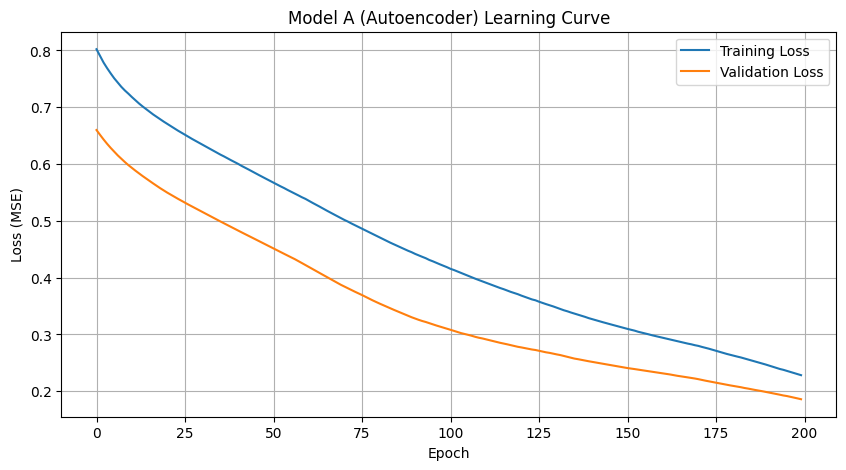


--- モデルA 再構成誤差の分布 ---


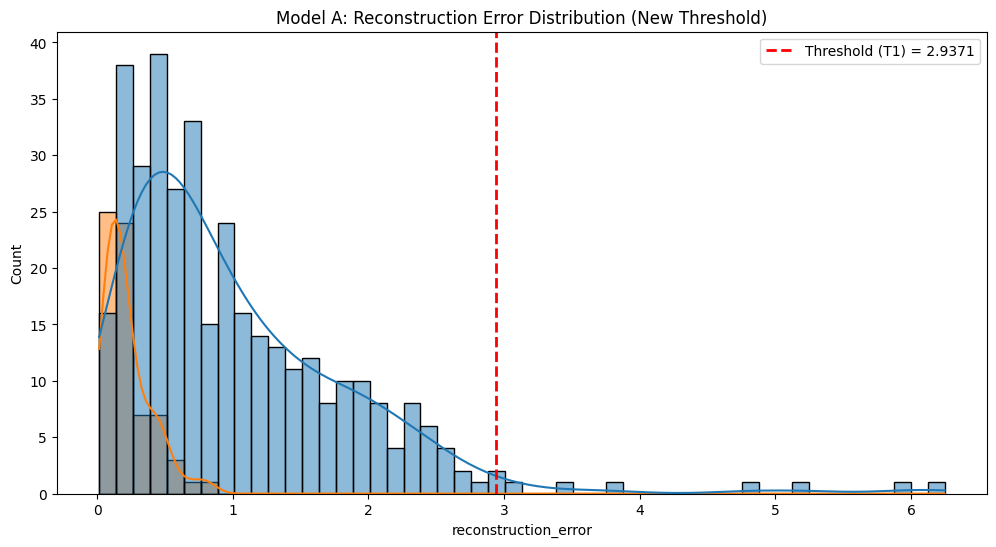


【新基準】で決定された異常検知の閾値 (T1): 2.937098


In [81]:
# --- 4. モデルA（門番・Autoencoder）の学習と可視化 ---

# 4.1 学習データの準備（良いポーズのみ）
# is_good_pose_train はステップ3でy_trainから計算可能ですが、
# 可視化のためにここで再定義しておくと分かりやすいです。
is_good_pose_train = train_df['source'] == 'good'
X_train_good_scaled = X_train_scaled[is_good_pose_train]

# 4.2 Autoencoderモデルの構築
input_dim = X_train_good_scaled.shape[1]
autoencoder = Sequential([
    Input(shape=(input_dim,)),
    Dense(8, activation='relu'),
    Dense(3, activation='relu'),
    Dense(8, activation='relu'),
    Dense(input_dim)
])
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
print("\n--- モデルA (Autoencoder) の学習開始 ---")

# 4.3 学習
autoencoder_history = autoencoder.fit(
    X_train_good_scaled, X_train_good_scaled,
    epochs=200,
    batch_size=16,
    shuffle=True,
    validation_split=0.1,
    verbose=1 # 学習の進捗を表示
)
print("--- 学習完了 ---")


# ★★★★★ ここからが可視化コードです ★★★★★

# 4.4 学習曲線の可視化
print("\n--- モデルA 学習曲線のプロット ---")
history_df = pd.DataFrame(autoencoder_history.history)
plt.figure(figsize=(10, 5))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Model A (Autoencoder) Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# --- 4.5 再構成誤差の分布の可視化と、閾値T1の決定 (新基準版) ---

print("\n--- モデルA 再構成誤差の分布 ---")
# 全ての訓練データで誤差を計算 (この部分は変更なし)
reconstructions = autoencoder.predict(X_train_scaled, verbose=0)
mse = np.mean(np.power(X_train_scaled - reconstructions, 2), axis=1)

is_good_pose_train = train_df['source'] == 'good'
df_error = pd.DataFrame({'reconstruction_error': mse, 'is_good': is_good_pose_train.values})


# ★★★★★ ここからが新しい閾値の計算ロジック ★★★★★

# 1. 「悪いポーズ」の誤差だけを抽出
# is_good_pose_trainがFalseのものが悪いポーズ
mse_bad_poses = mse[~is_good_pose_train.values]

# 2. 悪いポーズの95パーセンタイル点を閾値とする
T1_threshold = np.percentile(mse_bad_poses, 98)

# ★★★★★ 修正はここまで ★★★★★


# 可視化（変更なし）
plt.figure(figsize=(12, 6))
sns.histplot(data=df_error, x='reconstruction_error', hue='is_good', kde=True, bins=50)
plt.title('Model A: Reconstruction Error Distribution (New Threshold)')
plt.axvline(T1_threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold (T1) = {T1_threshold:.4f}')
plt.legend()
plt.show()

print(f"\n【新基準】で決定された異常検知の閾値 (T1): {T1_threshold:.6f}")
# T1_threshold = 3.129695


--- tf.dataパイプライン構築完了 ---

--- モデルB (2系統モデル) の学習開始 ---
Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.2699 - loss: 0.6635 - val_accuracy: 0.2533 - val_loss: 0.5990
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.3325 - loss: 0.5525 - val_accuracy: 0.2800 - val_loss: 0.5230
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.3848 - loss: 0.4569 - val_accuracy: 0.3200 - val_loss: 0.4525
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.4321 - loss: 0.3840 - val_accuracy: 0.3733 - val_loss: 0.3922
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.4541 - loss: 0.3362 - val_accuracy: 0.4800 - val_loss: 0.3126
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.5117 - loss: 0.2796 - val_accuracy: 0.5067 - val_loss: 0.2767
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.5528 - loss: 0.2128 - val_accuracy: 0.5333 - val_loss: 0.2395
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/

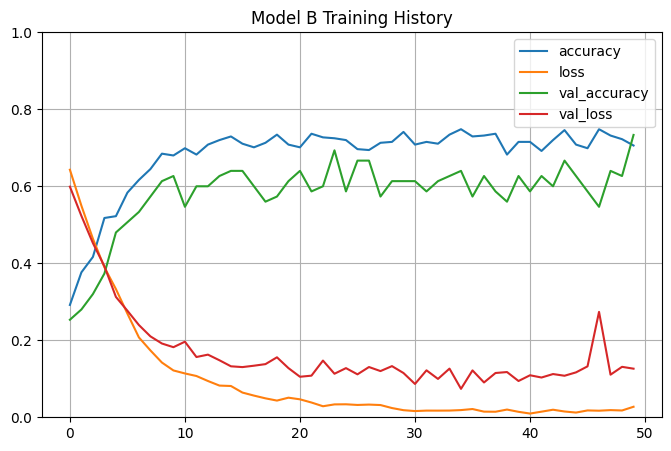

In [100]:
# --- 5. モデルB（専門医・2系統モデル）の学習 ---

# 5.1 データパイプラインの構築
IMG_SIZE = 224
BATCH_SIZE = 16

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.keras.applications.efficientnet_v2.preprocess_input(image)
    return image

def create_dataset_from_df(dataframe):
    # スケーリング済みの特徴量を使うように修正
    scaled_feature_values = scaler.transform(dataframe[feature_names])

    features_data = scaled_feature_values.astype('float32')
    path_data = dataframe['correct_path'].values
    labels_data = dataframe[error_labels].values.astype('float32')

    image_ds = tf.data.Dataset.from_tensor_slices(path_data).map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    features_ds = tf.data.Dataset.from_tensor_slices(features_data)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels_data)

    return tf.data.Dataset.zip(((image_ds, features_ds), labels_ds))

train_ds = create_dataset_from_df(train_df).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = create_dataset_from_df(test_df).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print("\n--- tf.dataパイプライン構築完了 ---")

# 5.2 モデルの構築
input_image = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image_input')
input_features = Input(shape=(len(feature_names),), name='features_input')
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_tensor=input_image)
base_model.trainable = False
x_image = base_model.output
x_image = GlobalAveragePooling2D()(x_image)
x_image = Dense(64, activation='relu')(x_image)
x_features = Dense(32, activation='relu')(input_features)
x_features = Dense(16, activation='relu')(x_features)
combined = Concatenate()([x_image, x_features])
x_combined = Dense(32, activation='relu')(combined)
x_combined = Dense(16, activation='relu')(x_combined)
output = Dense(len(error_labels), activation='sigmoid', name='output')(x_combined)
two_stream_model = Model(inputs=[input_image, input_features], outputs=output)
two_stream_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 5.3 モデルの学習
print("\n--- モデルB (2系統モデル) の学習開始 ---")
history = two_stream_model.fit(
    train_ds,
    epochs=50,
    validation_data=test_ds,
    verbose=1
)
print("--- 学習完了 ---")

# 5.4 学習曲線のプロット
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title("Model B Training History")
plt.show()

In [101]:
# ==============================================================================
# --- 7. 動画によるリアルタイムフィードバックシステム (修正版) ---
# ==============================================================================
!pip install mediapipe opencv-python
!pip install tqdm
import cv2
import mediapipe as mp
import time
from tqdm import tqdm # 進捗バーを表示するために追加
from copy import deepcopy

print("\n--- 7. 動画フィードバックシステムの準備 ---")


--- 7. 動画フィードバックシステムの準備 ---


In [102]:
# ## 6. システム全体の最終性能評価
# ---
# ここでは、学習済みのモデルを使い、テストデータセット (`test_df`) に対する総合的な精度を評価します。

# %%
# 6.1 ヘルパー関数: フィードバックキーを予測ベクトルに変換
def key_to_vector(key):
    """フィードバックキー（例: "error_ude_hiza"）を多ラベルベクトル（例: [1, 1, 0]）に変換する。"""
    if key == "abnormal": return [1, 1, 1]
    hiza = 1 if 'hiza' in key else 0
    ude = 1 if 'ude' in key else 0
    kakato = 1 if 'kakato' in key else 0
    return [hiza, ude, kakato]

# 6.2 評価実行関数
def evaluate_model_on_test_set(test_dataframe):
    """
    テストデータセット全体を推論し、分類レポートを出力する。
    """
    print("\n--- 最終性能評価を開始します ---")
    all_predictions = []
    y_true = test_dataframe[error_labels].values

    for index, row in tqdm(test_dataframe.iterrows(), total=len(test_dataframe), desc="テストデータを評価中"):
        # 画像とランドマークを取得
        image_path = row['correct_path']
        image = cv2.imread(image_path)
        if image is None:
            all_predictions.append([0, 0, 0])
            continue
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        landmarks_3d = row['landmarks']

        # エラーを推論（動画処理で使う関数を再利用）
        feedback_key, _, _ = predict_pose_errors(image_rgb, landmarks_3d)

        # 推論結果をベクトルに変換
        pred_vector = key_to_vector(feedback_key)
        all_predictions.append(pred_vector)

    # 評価指標を計算して表示
    y_pred = np.array(all_predictions)
    print("\n--- 最終推論パイプライン 評価レポート ---")
    print(classification_report(y_true, y_pred, target_names=error_labels, zero_division=0))
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    print(f"\n最終的な総合評価 (Macro-Average F1 Score): {macro_f1:.4f}")
    return macro_f1

In [ ]:
# 7.1 初期設定とヘルパー関数の定義

# --- 設定項目 ---
SKELETON_DRAW_HZ = 20
INFERENCE_HZ = 1
MODEL_B_THRESHOLD = 0.15

# MediaPipe Poseの準備
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose_detector = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=1,
    enable_segmentation=False,
    min_detection_confidence=0.5
)
BODY_CONNECTIONS = set([c for c in mp_pose.POSE_CONNECTIONS if c[0] > 10 and c[1] > 10])

# --- ★★★ フィードバック用画像のパスを新しい定義に更新 ★★★ ---
feedback_image_paths = {
    "no_pose":         './feedback_images/01_no_pose.JPG',
    "perfect":         './feedback_images/02_perfect.JPG',
    "error_hiza":      './feedback_images/03_hiza.JPG',
    "error_ude":       './feedback_images/04_ude.JPG',
    "error_kakato":    './feedback_images/05_kakato.JPG',
    "error_ude_hiza":  './feedback_images/06_ude_hiza.JPG',
    "error_ude_kakato":'./feedback_images/07_ude_kakato.JPG',
    "error_hiza_kakato":'./feedback_images/08_hiza_kakato.JPG',
    "abnormal":        './feedback_images/09_abnormal.JPG' # 門番 or 3つ全てのエラー
}

# フィードバック画像を事前に読み込んでおく
feedback_images = {name: cv2.imread(path) for name, path in feedback_image_paths.items()}
# 画像が見つからない場合のエラー処理
if any(img is None for img in feedback_images.values()):
    print("警告: フィードバック画像の一部が見つかりません。パスとファイル名を確認してください。")
    dummy_img = np.zeros((480, 480, 3), dtype=np.uint8)
    cv2.putText(dummy_img, 'IMG NOT FOUND', (30, 240), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)
    feedback_images = {name: img if img is not None else dummy_img for name, img in feedback_images.items()}


# --- エラー箇所に対応するランドマークのインデックスを定義 ---
if rear == 'RIGHT':
    error_landmark_indices = {
        'hiza': [mp_pose.PoseLandmark.RIGHT_KNEE.value],
        'ude': [mp_pose.PoseLandmark.LEFT_WRIST.value, mp_pose.PoseLandmark.LEFT_ELBOW.value, mp_pose.PoseLandmark.RIGHT_WRIST.value, mp_pose.PoseLandmark.RIGHT_ELBOW.value],
        'kakato': [mp_pose.PoseLandmark.RIGHT_HEEL.value]
    }
else:
    error_landmark_indices = {
        'hiza': [mp_pose.PoseLandmark.LEFT_KNEE.value],
        'ude': [mp_pose.PoseLandmark.LEFT_WRIST.value, mp_pose.PoseLandmark.LEFT_ELBOW.value, mp_pose.PoseLandmark.RIGHT_WRIST.value, mp_pose.PoseLandmark.RIGHT_ELBOW.value],
        'kakato': [mp_pose.PoseLandmark.LEFT_HEEL.value]
    }


I0000 00:00:1751987917.300940  626401 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1751987917.362252  882569 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 560.28.03), renderer: NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2


W0000 00:00:1751987917.439046  882535 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751987917.469813  882552 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [104]:
from mediapipe.framework.formats import landmark_pb2

def smooth_landmarks(current_landmarks, previous_landmarks, alpha=0.5):
    """
    ランドマークを時間的に平滑化（Exponential Moving Average）する。
    alpha: 平滑化の強さ。0に近いほど滑らか（遅延は大きい）、1に近いほど生のデータに近い。
    """
    if previous_landmarks is None:
        return current_landmarks

    smoothed_landmarks = landmark_pb2.NormalizedLandmarkList()

    for i in range(len(current_landmarks.landmark)):
        prev_lm = previous_landmarks.landmark[i]
        curr_lm = current_landmarks.landmark[i]

        smoothed_lm = smoothed_landmarks.landmark.add()
        smoothed_lm.x = alpha * curr_lm.x + (1.0 - alpha) * prev_lm.x
        smoothed_lm.y = alpha * curr_lm.y + (1.0 - alpha) * prev_lm.y
        smoothed_lm.z = alpha * curr_lm.z + (1.0 - alpha) * prev_lm.z
        smoothed_lm.visibility = curr_lm.visibility

    return smoothed_landmarks

In [105]:
# 7.2 描画およびリサイズ用ヘルパー関数 (このセクションは変更なし)
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# ─────────────────────────────────────────────────────
# 左右どちらをエラー対象とするかを動的に切り替える辞書
BASE_ERROR_LANDMARK_INDICES = {
    'hiza': {
        'left':  [mp_pose.PoseLandmark.LEFT_KNEE.value],
        'right': [mp_pose.PoseLandmark.RIGHT_KNEE.value],
    },
    'ude': {
        'left':  [mp_pose.PoseLandmark.LEFT_WRIST.value,
                  mp_pose.PoseLandmark.LEFT_ELBOW.value],
        'right': [mp_pose.PoseLandmark.RIGHT_WRIST.value,
                  mp_pose.PoseLandmark.RIGHT_ELBOW.value],
    },
    'kakato': {
        'left':  [mp_pose.PoseLandmark.LEFT_HEEL.value],
        'right': [mp_pose.PoseLandmark.RIGHT_HEEL.value],
    },
}
# ─────────────────────────────────────────────────────



def draw_custom_landmarks(image, landmarks, connections, error_keys):
    """
    骨格を描画する関数。顔は非表示にし、エラー箇所は赤い円で囲む。
    """
    # ★★★ 修正点1：顔のランドマークの点を非表示にする処理 ★★★
    # 元のデータに影響を与えないよう、ディープコピーを作成
    landmarks_body_only = deepcopy(landmarks)
    # 顔のランドマーク（index 0～10）のvisibilityを0に設定して見えなくする
    for i in range(11):
        landmarks_body_only.landmark[i].visibility = 0
    
       # 2. ★ どちらの足が「左／右」かを判定
    try:
        l_heel = landmarks.landmark[mp_pose.PoseLandmark.LEFT_HEEL.value]
        r_heel = landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HEEL.value]
        # 画面座標系：x が大きいほど右側
        target_side = 'left' if l_heel.x < r_heel.x else 'right'
    except (IndexError, AttributeError):
        # 座標が取得できない・異常時はデフォルトで left
        target_side = 'left'

    # 3. error_indices_set を動的に生成
    error_indices_set = set()
    for key in error_keys:
        if key in BASE_ERROR_LANDMARK_INDICES:
            error_indices_set.update(
                BASE_ERROR_LANDMARK_INDICES[key][target_side]
            )

    # # エラー箇所の特定（変更なし）
    # error_indices_set = set()
    # for key in error_keys:
    #     if key in error_landmark_indices:
    #         error_indices_set.update(error_landmark_indices[key])

    # 体の骨格を緑で描画（landmarks_body_onlyを使用）
    mp_drawing.draw_landmarks(
        image=image,
        landmark_list=landmarks_body_only, # 顔を非表示にしたデータを使用
        connections=connections,           # BODY_CONNECTIONSが渡される
        landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=-1, circle_radius=4),
        connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2)
    )

    # エラー箇所を赤い円で上書き描画（変更なし）
    if landmarks:
        for idx in error_indices_set:
            # 元のlandmarkデータを使って位置を計算
            lm = landmarks.landmark[idx]
            h, w, _ = image.shape
            if lm.visibility > 0.5:
                cx, cy = int(lm.x * w), int(lm.y * h)
                cv2.circle(image, (cx, cy), 20, (0, 0, 255), 3)


def combine_videos(frame_left, frame_right):
    """
    左のフレームの高さに合わせて右のフレームをリサイズし、横に結合する。
    """
    h_left, w_left, _ = frame_left.shape
    h_right, w_right, _ = frame_right.shape

    scale = h_left / h_right
    new_w_right = int(w_right * scale)
    frame_right_resized = cv2.resize(frame_right, (new_w_right, h_left))

    combined_frame = np.concatenate((frame_left, frame_right_resized), axis=1)
    return combined_frame

In [106]:
# 7.3 推論パイプライン関数 (修正版)

def predict_pose_errors(frame, landmarks_3d):
    """
    1フレームとランドマーク情報から、エラー内容を推論する。（新しいキーに対応）
    """
    # 1. 特徴量抽出
    features = extract_final_features(landmarks_3d)
    features_scaled = scaler.transform([features])

    # 2. モデルA (Autoencoder) で異常検知
    reconstruction = autoencoder.predict(features_scaled, verbose=0)
    mse = np.mean(np.power(features_scaled - reconstruction, 2), axis=1)[0]

    if mse > T1_threshold:
        return "abnormal", mse, ['hiza', 'ude', 'kakato'] # abnormal時は全箇所をエラーとして表示

    # 3. モデルB (2系統モデル) でエラー分類
    img_resized = tf.image.resize(frame, [IMG_SIZE, IMG_SIZE])
    img_preprocessed = tf.keras.applications.efficientnet_v2.preprocess_input(img_resized)
    img_tensor = tf.expand_dims(img_preprocessed, axis=0)
    features_tensor = tf.convert_to_tensor(features_scaled.astype('float32'))

    predictions = two_stream_model.predict([img_tensor, features_tensor], verbose=0)[0]
    pred_labels = (predictions > MODEL_B_THRESHOLD).astype(int)

    # 4. ★★★ フィードバックロジックを新しいキーに合わせて修正 ★★★
    error_keys = []
    if pred_labels[0]: error_keys.append('hiza')
    if pred_labels[1]: error_keys.append('ude')
    if pred_labels[2]: error_keys.append('kakato')

    num_errors = len(error_keys)
    feedback_key = ""

    if num_errors >= 3:
        feedback_key = "abnormal"
    elif num_errors == 2:
        if 'ude' in error_keys and 'hiza' in error_keys:
            feedback_key = "error_ude_hiza"
        elif 'ude' in error_keys and 'kakato' in error_keys:
            feedback_key = "error_ude_kakato"
        elif 'hiza' in error_keys and 'kakato' in error_keys:
            feedback_key = "error_hiza_kakato"
    elif num_errors == 1:
        feedback_key = f"error_{error_keys[0]}"
    else:
        feedback_key = "perfect"

    return feedback_key, mse, error_keys


In [107]:
# 7.4 動画処理のメイン実行関数 (修正版)

def process_video_with_feedback(input_video_path, output_video_path):
    """
    動画を読み込み、AIフィードバックを付けて新しい動画として保存する。（新しいキーに対応）
    """
    print(f"\n--- 動画処理開始: {input_video_path} ---")
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print(f"エラー: 動画ファイルが開けません: {input_video_path}")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    out = None
    draw_interval = 1.0 / SKELETON_DRAW_HZ
    inference_interval = 1.0 / INFERENCE_HZ
    last_draw_time = -draw_interval
    last_inference_time = -inference_interval

    last_landmarks = None
    last_error_keys = []
    # ★★★ 初期状態のキーを 'perfect' に変更 ★★★
    current_feedback_key = "perfect"

    pbar = tqdm(total=total_frames, desc="Processing Video")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        current_time = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        if (current_time - last_draw_time) >= draw_interval:
            last_draw_time = current_time
            results = pose_detector.process(frame_rgb)
            if results.pose_landmarks:
                last_landmarks = results.pose_landmarks

        if (current_time - last_inference_time) >= inference_interval:
            last_inference_time = current_time
            if last_landmarks and results.pose_world_landmarks:
                landmarks_3d = {lm.name: {'x': data.x, 'y': data.y, 'z': data.z}
                                for lm, data in zip(mp_pose.PoseLandmark, results.pose_world_landmarks.landmark)}
                feedback_key, mse, error_keys = predict_pose_errors(frame_rgb, landmarks_3d)
                current_feedback_key = feedback_key
                last_error_keys = error_keys
            else:
                # ★★★ 骨格未検出時のキーを 'no_pose' に変更 ★★★
                current_feedback_key = "no_pose"
                last_error_keys = []

        annotated_image = frame.copy()
        if last_landmarks:
            draw_custom_landmarks(annotated_image, last_landmarks, BODY_CONNECTIONS, last_error_keys)

        feedback_image = feedback_images[current_feedback_key]
        combined_output_frame = combine_videos(annotated_image, feedback_image)

        if out is None:
            h, w, _ = combined_output_frame.shape
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_video_path, fourcc, fps, (w, h))

        out.write(combined_output_frame)
        pbar.update(1)

    cap.release()
    if out:
      out.release()
    pbar.close()
    print(f"--- 動画処理完了: {output_video_path} に保存しました ---")


In [108]:
# ## 8. 実行ブロック
# ---
# ここで、実行したい処理を選択します。

# %%
# --- 実行したい処理のコメントを外してください ---

# 【A】テストデータセット全体でモデルの最終性能を評価する場合
evaluate_model_on_test_set(test_df)


--- 最終性能評価を開始します ---


テストデータを評価中:   0%|          | 0/75 [00:00<?, ?it/s]/home/mhoshino/anaconda3/envs/yoga/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
テストデータを評価中:   1%|▏         | 1/75 [00:01<02:14,  1.82s/it]/home/mhoshino/anaconda3/envs/yoga/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
テストデータを評価中:   3%|▎         | 2/75 [00:02<01:32,  1.26s/it]/home/mhoshino/anaconda3/envs/yoga/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
テストデータを評価中:   4%|▍         | 3/75 [00:02<00:55,  1.29it/s]/home/mhoshino/anaconda3/envs/yoga/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid f


--- 最終推論パイプライン 評価レポート ---
              precision    recall  f1-score   support

  error_hiza       0.85      0.93      0.89        30
   error_ude       0.91      0.97      0.94        30
error_kakato       0.88      0.97      0.92        30

   micro avg       0.88      0.96      0.91        90
   macro avg       0.88      0.96      0.92        90
weighted avg       0.88      0.96      0.92        90
 samples avg       0.76      0.79      0.77        90


最終的な総合評価 (Macro-Average F1 Score): 0.9150


0.9150025601638504

In [109]:
# 【B】動画ファイルを処理して、フィードバック付きの動画を生成する場合
INPUT_VIDEO = './input_videos/video_01.mp4'
OUTPUT_VIDEO = './output_videos/final_interactive_video_01.mp4'

process_video_with_feedback(INPUT_VIDEO, OUTPUT_VIDEO)


--- 動画処理開始: ./input_videos/video_01.mp4 ---


Processing Video:   0%|          | 0/1694 [00:00<?, ?it/s]

Processing Video:   2%|▏         | 30/1694 [00:00<00:49, 33.50it/s]/home/mhoshino/anaconda3/envs/yoga/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Processing Video:   3%|▎         | 58/1694 [00:01<00:52, 31.06it/s]/home/mhoshino/anaconda3/envs/yoga/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Processing Video:   5%|▌         | 90/1694 [00:02<00:47, 33.52it/s]/home/mhoshino/anaconda3/envs/yoga/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Processing Video:   7%|▋         | 118/1694 [00:03<00:47, 33.08it/s]/home/mhoshino/anaconda3/envs/yoga/lib/python3.11/site-packages/sklearn/utils/validation.

--- 動画処理完了: ./output_videos/final_interactive_video_01.mp4 に保存しました ---


In [110]:
# 【B】動画ファイルを処理して、フィードバック付きの動画を生成する場合
INPUT_VIDEO = './input_videos/video_02.mp4'
OUTPUT_VIDEO = './output_videos/final_interactive_video_02.mp4'

process_video_with_feedback(INPUT_VIDEO, OUTPUT_VIDEO)


--- 動画処理開始: ./input_videos/video_02.mp4 ---


Processing Video:   4%|▎         | 61/1636 [00:01<00:45, 34.69it/s]/home/mhoshino/anaconda3/envs/yoga/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Processing Video:   5%|▌         | 88/1636 [00:02<00:47, 32.78it/s]/home/mhoshino/anaconda3/envs/yoga/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Processing Video:   7%|▋         | 120/1636 [00:03<00:45, 33.55it/s]/home/mhoshino/anaconda3/envs/yoga/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Processing Video:   9%|▉         | 148/1636 [00:04<00:47, 31.10it/s]/home/mhoshino/anaconda3/envs/yoga/lib/python3.11/site-packages/sklearn/utils/validation

--- 動画処理完了: ./output_videos/final_interactive_video_02.mp4 に保存しました ---


In [111]:
# 【B】動画ファイルを処理して、フィードバック付きの動画を生成する場合
INPUT_VIDEO = './input_videos/video_03.mp4'
OUTPUT_VIDEO = './output_videos/final_interactive_video_03.mp4'

process_video_with_feedback(INPUT_VIDEO, OUTPUT_VIDEO)


--- 動画処理開始: ./input_videos/video_03.mp4 ---


Processing Video:   5%|▌         | 90/1707 [00:02<00:48, 33.01it/s]/home/mhoshino/anaconda3/envs/yoga/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Processing Video:   7%|▋         | 118/1707 [00:03<00:47, 33.40it/s]/home/mhoshino/anaconda3/envs/yoga/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Processing Video:   9%|▉         | 150/1707 [00:04<00:46, 33.47it/s]/home/mhoshino/anaconda3/envs/yoga/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Processing Video:  10%|█         | 178/1707 [00:05<00:42, 35.75it/s]/home/mhoshino/anaconda3/envs/yoga/lib/python3.11/site-packages/sklearn/utils/validatio

--- 動画処理完了: ./output_videos/final_interactive_video_03.mp4 に保存しました ---


In [112]:
# 【B】動画ファイルを処理して、フィードバック付きの動画を生成する場合
INPUT_VIDEO = './input_videos/video_04.mp4'
OUTPUT_VIDEO = './output_videos/final_interactive_video_04.mp4'

process_video_with_feedback(INPUT_VIDEO, OUTPUT_VIDEO)


--- 動画処理開始: ./input_videos/video_04.mp4 ---


Processing Video:   0%|          | 0/1707 [00:00<?, ?it/s]

Processing Video:   3%|▎         | 59/1707 [00:02<00:50, 32.79it/s]/home/mhoshino/anaconda3/envs/yoga/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Processing Video:   5%|▌         | 90/1707 [00:03<00:53, 30.40it/s]/home/mhoshino/anaconda3/envs/yoga/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Processing Video:   7%|▋         | 118/1707 [00:04<00:48, 32.70it/s]/home/mhoshino/anaconda3/envs/yoga/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Processing Video:   9%|▉         | 150/1707 [00:05<00:45, 34.42it/s]/home/mhoshino/anaconda3/envs/yoga/lib/python3.11/site-packages/sklearn/utils/validation

--- 動画処理完了: ./output_videos/final_interactive_video_04.mp4 に保存しました ---
